# 思路
- 收集数据：提供文本数据
- 准备数据：解析文本数据
- 分析数据：使用matplotlib 二维扩散图
- 训练算法：不适用于k-近邻
- 测试算法：切分测试样本； 测试样本是已经完成分类的数据，如果预测分类与实际分类不同，则标记为错误
- 使用算法：程序执行，输入一些特征数据来判断是否为喜欢的类型
    - 三种类型：不喜欢的、一般的、喜欢的

### 准备数据

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import operator

In [2]:
np.zeros((1000,3)).shape

(1000, 3)

In [3]:
def file2matrix(filename):
    with open (filename,'r') as f:
        arrayOLines = f.readlines()
#         print(arrayLines)
        numberOflines= len(arrayOLines)
#         print(numberOflines)
        returnMat = np.zeros((numberOflines,3)) # 创建numpy矩阵
#         print(returnMat)
        classLabelVector = []
        index= 0
        for line in arrayOLines:
            line = line.strip()
#             print(line)
            listFromLine = line.split('\t')
#             print(listFromLine)
            # x[:,n]表示在全部数组（维）中取第n个数据，直观来说，x[:,n]就是取所有集合的第n个数据, 
            # x[n,:]表示在n个数组（维）中取全部数据，直观来说，x[n,:]就是取第n集合的所有数据, 
        
            returnMat[index,:] = listFromLine[0:3]
#             print(returnMat)
            classLabelVector.append(int(listFromLine[-1]))
#             print(classLabelVector)
            index +=1
        return returnMat,classLabelVector

In [4]:
# 每年获得的飞行常客里程数、玩视频游戏所耗时间的占比、每周消费的冰淇淋公升数
datingDataMat,datingLabels =file2matrix("./dataset/datingTestSet2.txt")

In [5]:
datingDataMat

array([[4.0920000e+04, 8.3269760e+00, 9.5395200e-01],
       [1.4488000e+04, 7.1534690e+00, 1.6739040e+00],
       [2.6052000e+04, 1.4418710e+00, 8.0512400e-01],
       ...,
       [2.6575000e+04, 1.0650102e+01, 8.6662700e-01],
       [4.8111000e+04, 9.1345280e+00, 7.2804500e-01],
       [4.3757000e+04, 7.8826010e+00, 1.3324460e+00]])

In [6]:
datingLabels[0:20]

[3, 2, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3]

### 分析数据

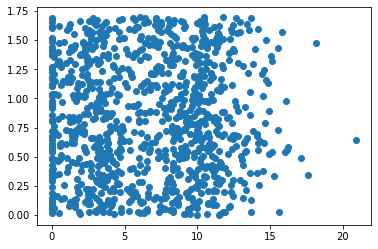

In [7]:
fig=  plt.figure()
ax = fig.add_subplot(111)
# 第二列和第三列数据
ax.scatter(datingDataMat[:,1], datingDataMat[:,2])
plt.show()

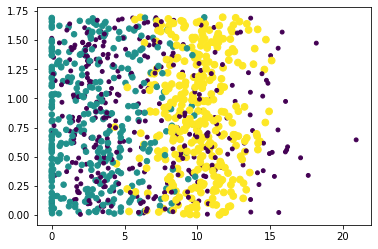

In [8]:
fig=  plt.figure()
ax = fig.add_subplot(111)
# 第二列和第三列数据
ax.scatter(datingDataMat[:,1], datingDataMat[:,2], 15.0*np.array(datingLabels) , 15.0*np.array(datingLabels))
plt.show()

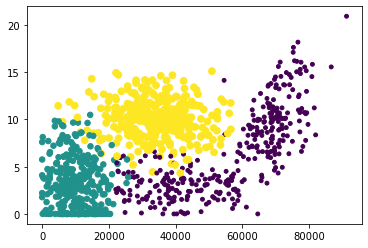

In [9]:
fig=  plt.figure()
ax = fig.add_subplot(111)
# 第二列和第三列数据
ax.scatter(datingDataMat[:,0], datingDataMat[:,1], 15.0*np.array(datingLabels) , 15.0*np.array(datingLabels))
plt.show()

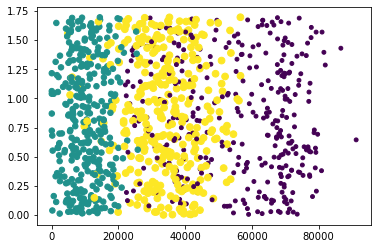

In [10]:
fig=  plt.figure()
ax = fig.add_subplot(111)
# 第二列和第三列数据
ax.scatter(datingDataMat[:,0], datingDataMat[:,2], 15.0*np.array(datingLabels) , 15.0*np.array(datingLabels))
plt.show()

### 准备数据：归一化数据

- 将数值归一化，如将取值范围 8 处理为0到1或者-1到1之间
newValue = (oldValue -min) / (max-min)

In [18]:
def autoNorm(dataSet):
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    ranges = maxVals- minVals
    normDataSet = np.zeros(np.shape(dataSet))
    m = dataSet.shape[0] # 行数
#     print(m) 
    normDataSet = dataSet - np.tile(minVals , (m,1))
    normDataSet = normDataSet / np.tile(ranges,(m,1))  # 特征值相除
    return normDataSet,ranges,minVals

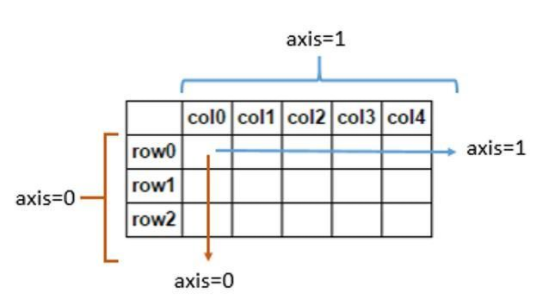

In [19]:
datingDataMat.shape

(1000, 3)

In [21]:
normMat , ranges, minVals = autoNorm(datingDataMat)

1000


In [30]:
normMat

array([[0.44832535, 0.39805139, 0.56233353],
       [0.15873259, 0.34195467, 0.98724416],
       [0.28542943, 0.06892523, 0.47449629],
       ...,
       [0.29115949, 0.50910294, 0.51079493],
       [0.52711097, 0.43665451, 0.4290048 ],
       [0.47940793, 0.3768091 , 0.78571804]])

In [42]:
normMat[10:20,:]

array([[0.55045851, 0.17799301, 0.49030933],
       [0.69324992, 0.40086711, 0.9846361 ],
       [0.06101476, 0.23305864, 0.42936659],
       [0.55933299, 0.22372102, 0.36832056],
       [0.84769866, 0.73135976, 0.19487878],
       [0.47848761, 0.09032121, 0.11221162],
       [0.67231273, 0.35932065, 0.74836944],
       [0.76334732, 0.68067104, 0.15355464],
       [0.1716718 , 0.        , 0.73716817],
       [0.31211859, 0.50329267, 0.76942753]])

In [23]:
datingDataMat.min(0).shape

array([9.1273000e+04, 2.0919349e+01, 1.6943610e+00])

In [24]:
minVals

array([0.      , 0.      , 0.001156])

In [61]:
def classify0(inX, dataSet, labels, k):
    # shape[0]：表示矩阵的行数
    # shape[1]：表示矩阵的列数
    dataSetSize = dataSet.shape[0]
#     print(dataSetSize)
    # 距离计算
    # np.tile(a,(2,1))第一个参数为Y轴扩大倍数，第二个为X轴行扩大倍数。
    # np.tile（a,(2)）函数的作用就是将函数将函数沿着X轴/行扩大两倍。如果扩大倍数只有一个，默认为X轴
    diffMat = np.tile(inX, (dataSetSize,1))-dataSet
    sqDiffMat = diffMat ** 2
    sqDistances = sqDiffMat.sum(axis=1)
    distances = sqDistances ** 0.5
    sortedDistIndicies = distances.argsort()
#     print(sortedDistIndicies)
    # 选择距离最小的k个点
    classCount={}
    for i in range(k):
        voteIlabel = labels[sortedDistIndicies[i]]
        print("voteIlabel:",voteIlabel)
        classCount[voteIlabel]= classCount.get(voteIlabel,0) +1
        print("classCount[voteIlabel]:",classCount[voteIlabel])
        print("classCount:",classCount)
    # 排序
    sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

### 测试算法：作为完整程序验证分类器

- 通常使用90%作为训练样本来训练分类器，使用其余的10%数据去测试分类器

In [62]:
def datingClassTest():
    hoRatio = 0.10
    datingDataMat ,datingLabels = file2matrix("./dataset/datingTestSet2.txt")
    normMat, ranges, minVals = autoNorm(datingDataMat)
    m = normMat.shape[0]
    numTestVecs = int(m * hoRatio)
    print(numTestVecs)
    errorCount = 0.0
    for i in range(numTestVecs):
        classifierResult = classify0(normMat[i,:], normMat[numTestVecs:m,:], datingLabels[numTestVecs:m],3)
#         print("最近邻的结果",classifierResult,"realanswer", datingLabels[i])
        if (classifierResult != datingLabels[i]):
            errorCount +=1.0
    print("正确率",1.0-errorCount/float(numTestVecs))

In [63]:
datingClassTest()

1000
100
voteIlabel: 3
classCount[voteIlabel]: 1
classCount: {3: 1}
voteIlabel: 3
classCount[voteIlabel]: 2
classCount: {3: 2}
voteIlabel: 3
classCount[voteIlabel]: 3
classCount: {3: 3}
voteIlabel: 2
classCount[voteIlabel]: 1
classCount: {2: 1}
voteIlabel: 3
classCount[voteIlabel]: 1
classCount: {2: 1, 3: 1}
voteIlabel: 2
classCount[voteIlabel]: 2
classCount: {2: 2, 3: 1}
voteIlabel: 1
classCount[voteIlabel]: 1
classCount: {1: 1}
voteIlabel: 1
classCount[voteIlabel]: 2
classCount: {1: 2}
voteIlabel: 1
classCount[voteIlabel]: 3
classCount: {1: 3}
voteIlabel: 1
classCount[voteIlabel]: 1
classCount: {1: 1}
voteIlabel: 1
classCount[voteIlabel]: 2
classCount: {1: 2}
voteIlabel: 1
classCount[voteIlabel]: 3
classCount: {1: 3}
voteIlabel: 1
classCount[voteIlabel]: 1
classCount: {1: 1}
voteIlabel: 1
classCount[voteIlabel]: 2
classCount: {1: 2}
voteIlabel: 1
classCount[voteIlabel]: 3
classCount: {1: 3}
voteIlabel: 1
classCount[voteIlabel]: 1
classCount: {1: 1}
voteIlabel: 1
classCount[voteIlabel

In [55]:
def classifyPerson():
    resultList=['not at all','in small doses','in large doses']
    percentTats = float(input("percentage of time spent playing video games?"))
    ffMiles = float(input("frequent flier miles per year?"))
    iceCream = float(input("liters of ice cream per week?"))
    datingDataMat, datingLabels = file2matrix("./dataset/datingTestSet2.txt")
    normMat ,ranges, minVals = autoNorm(datingDataMat)
    
    inArr=  np.array([ffMiles,percentTats,iceCream])
    classifierResult = classify0((inArr-minVals)/ranges , normMat, datingLabels ,3)
    print("probably result:",resultList[classifierResult-1])

In [57]:
classifyPerson()

percentage of time spent playing video games? 12
frequent flier miles per year? 999
liters of ice cream per week? 2


1000
1000
voteIlabel 2
voteIlabel 3
voteIlabel 3
probably result: in large doses


In [64]:
classifyPerson()

percentage of time spent playing video games? 10
frequent flier miles per year? 10000
liters of ice cream per week? 0.5


1000
voteIlabel: 2
classCount[voteIlabel]: 1
classCount: {2: 1}
voteIlabel: 2
classCount[voteIlabel]: 2
classCount: {2: 2}
voteIlabel: 3
classCount[voteIlabel]: 1
classCount: {2: 2, 3: 1}
probably result: in small doses
